In [1]:
# Importing Libraries
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yaml
import matplotlib.dates as mdates
import os
import numpy as np
import yfinance as yf
import matplotlib.font_manager as fm
import matplotlib.ticker as mticker

# Set maximum number of columns to display
pd.set_option('display.max_columns', 20)

In [2]:
# General Functions
def import_flow_data(processed_path, flow_breakdown, data_type="primary"):
    """
    Imports data for a given flow breakdown from a Parquet file.

    Parameters:
    - processed_path (str): The directory where the processed files are stored.
    - flow_breakdown (str): The flow breakdown identifier.

    Returns:
    - DataFrame: The loaded dataset.
    """
    # Construct the file path
    file_path = os.path.join(processed_path, f"{data_type}_{flow_breakdown}.parquet")
    
    # Try to load the dataset
    try:
        dataset = pd.read_parquet(file_path)
        print(f"Successfully loaded dataset for flow breakdown: {flow_breakdown}")
        return dataset
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None

def select_subdataset(dataset, country_code, unit_measure, energy_product):
    # Selecting Data
    sub_dataset = dataset[(dataset["REF_AREA"] == country_code) & (dataset["UNIT_MEASURE"] == unit_measure) & (dataset["ENERGY_PRODUCT"] == energy_product)]
    
    # Create new columns
    sub_dataset["DATE"] = pd.to_datetime(sub_dataset["TIME_PERIOD"] + "-01")
    sub_dataset["YEAR"] = sub_dataset["DATE"].dt.year
    sub_dataset["MONTH"] = sub_dataset["DATE"].dt.month
    
    # Ensure OBS_VALUE is numeric
    sub_dataset["OBS_VALUE"] = pd.to_numeric(sub_dataset["OBS_VALUE"], errors='coerce')
    
    print(sub_dataset["ASSESSMENT_CODE"].unique())
    
    return sub_dataset

def pivot_table_obs_value(dataset):
    # Pivot the table
    pivot_table = dataset.pivot_table(
        index="MONTH",
        columns="YEAR",
        values="OBS_VALUE",
        aggfunc="sum"  # Use sum, mean, or another aggregation function if there are duplicates
    )
    
    # Sort columns in descending order
    pivot_table = pivot_table.reindex(sorted(pivot_table.columns, reverse=True), axis=1)
    
    return pivot_table

def plot_seasonal_trends(pivot_dataset, chart_name, chart_title, unit_measure, country_code):
    # Paths to your Montserrat font files
    font_path = './assets/Montserrat/static/Montserrat-Regular.ttf'
    font_path_bold = './assets/Montserrat/static/Montserrat-Black.ttf'
    
    # Register the font properties
    prop = fm.FontProperties(fname=font_path)
    prop_bold = fm.FontProperties(fname=font_path_bold)

    # Prepare data
    plot_data = pivot_dataset.copy()
    
    # Select the columns from the second to the sixth (excluding the first column)
    plot_data = plot_data.iloc[:,0:6]
    fiveYearsRange = plot_data.iloc[:, 1:6]
    
    # Calculate the 5-year max, min, and average for each row
    plot_data["5YrMax"] = fiveYearsRange.max(axis=1)
    plot_data["5YrMin"] = fiveYearsRange.min(axis=1)
    plot_data["5YrAvg"] = fiveYearsRange.mean(axis=1)
    
    plot_data['5YrMax'].fillna(method='bfill', inplace=True)  # Forward fill
    plot_data['5YrMin'].fillna(method='bfill', inplace=True)  # Backward fill
    
    # Get the list of columns
    years = plot_data.columns.tolist()
    
    # Identify current year and previous year (assumes columns are sorted in descending order)
    current_year = years[0]
    previous_year = years[1]
    
    # Ensure plot_data is sorted by index
    plot_data = plot_data.sort_index()

    # Create a numerical range for the x-axis
    x_values = np.arange(len(plot_data)) + 1

    # Set up the figure size
    plt.figure(figsize=(7, 5))  # 60% of A4 landscape size

    # Plot the 5-Year Max/Min range as a shaded area
    plt.fill_between(x_values, plot_data['5YrMax'], plot_data['5YrMin'], color='lightgray', label='5-Year Range')

    # Colors
    five_year_avg_color = "black"
    five_year_previous_year = "#FFA500"
    five_year_current_year = "#003366"

    # Plot the 5-Year Average
    plt.plot(plot_data.index, plot_data['5YrAvg'], color=five_year_avg_color, linestyle='--', label='5-Year Average', linewidth=1)

    # Plot the previous year's values
    plt.plot(plot_data.index, plot_data[previous_year], color=five_year_previous_year, label=f'{previous_year}', linewidth=1.5, alpha=0.7)

    # Plot the current year's values
    plt.plot(plot_data.index, plot_data[current_year], color=five_year_current_year, marker='o', label=f'{current_year}', linewidth=2)

    # Format the y-axis with a dot as the thousand separator
    def thousands(x, pos):
        return f'{int(x):,}'.replace(',', '.')  # Format as '10.000', '20.000', etc.

    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(thousands))
    
    y_label = f"{unit_measure}"
    
    # Customize the plot with Montserrat font
    plt.title(chart_title, fontsize=24, fontproperties=prop_bold)
    plt.xlabel("Month", fontsize=12, fontproperties=prop)
    plt.ylabel(y_label, fontsize=12, fontproperties=prop)

    # Position the legend in the top-left corner with a highlighted background
    legend = plt.legend(
        loc='upper left', 
        bbox_to_anchor=(0, 1),  # Place legend outside the plot
        fontsize=10, 
        frameon=True,  # Enable frame
        prop=prop
    )
    legend.get_frame().set_facecolor('white')  # Set background color
    legend.get_frame().set_alpha(0.8)  # Make it semi-transparent
    legend.get_frame().set_edgecolor('black')  # Add a border color

    plt.grid(True)
    plt.tight_layout()

    # Save the plot as a PNG file
    # Ensure the folder exists
    export_path = f"../report/images/{country_code}"
    os.makedirs(export_path, exist_ok=True)
    export_file_name = chart_name.replace(" ", "_") + ".png"
    export_file_path = os.path.join(export_path, export_file_name)
    plt.savefig(export_file_path, bbox_inches='tight')
    
    # plt.show()  # Displays the plot

    # plt.close()  # Closes the current figure
    
    return None

# Z-Score for 10 Years
def z_score_metric(pivot_subdataset):
    
    z_score_columns = []
    
    rowIndex = 1
    i = 0
    
    while rowIndex < 7:
        # Current Year
        z_score_dataset = pivot_subdataset.iloc[:,rowIndex:(12+i)]
        tenYearsRange = pivot_subdataset.iloc[:, rowIndex:(12+i)]
        
        # # Calculate the 10-year mean and std for each row
        z_score_dataset["TimeAverage"] = tenYearsRange.mean(axis=1)
        z_score_dataset["TimeStd"] = tenYearsRange.std(axis=1)
        
        # Calculate the 10-year mean and std for each row (e.g., each month)
        z_score_dataset["TimeAverage"] = tenYearsRange.mean(axis=1)
        z_score_dataset["TimeStd"] = tenYearsRange.std(axis=1)
        
        # Calculate the Z-score for the current year (assuming it's the first column)
        current_year_column = z_score_dataset.columns[0]  # First column of the dataset
        z_score_year = (
            (z_score_dataset[current_year_column] - z_score_dataset["TimeAverage"]) 
            / z_score_dataset["TimeStd"]
        )
        
        z_score_columns.append(z_score_year)
        
        rowIndex += 1
        i += 1
    
        # Create a DataFrame
    zScore_dataset = pd.DataFrame({
        f'{pivot_subdataset.columns[0]}': z_score_columns[0],
        f'{pivot_subdataset.columns[1]}': z_score_columns[1],
        f'{pivot_subdataset.columns[2]}': z_score_columns[2],
        f'{pivot_subdataset.columns[3]}': z_score_columns[3],
        f'{pivot_subdataset.columns[4]}': z_score_columns[4],
        f'{pivot_subdataset.columns[5]}': z_score_columns[5],
    })
    
    return zScore_dataset

def zscore_plot(pivot_dataset, chart_name, chart_title, country_code):
    # Paths to your Montserrat font files
    font_path = './assets/Montserrat/static/Montserrat-Regular.ttf'
    font_path_bold = './assets/Montserrat/static/Montserrat-Black.ttf'
    
    # Register the font properties
    prop = fm.FontProperties(fname=font_path)
    prop_bold = fm.FontProperties(fname=font_path_bold)

    # Prepare data
    plot_data = pivot_dataset.copy()
    
    # Get the list of columns
    years = plot_data.columns.tolist()
    
    # Identify current year, previous year, and previous previous year (assumes columns are sorted in descending order)
    current_year_col = years[0]
    previous_year_col = years[1]
    previous_previous_year_col = years[2]
    
    # Ensure plot_data is sorted by index
    plot_data = plot_data.sort_index()

    # Set up the figure size
    plt.figure(figsize=(7, 5))  # 60% of A4 landscape size

    # Colors
    color_previous_previous_year = "#800080"  # Purple
    color_previous_year = "#FFA500"          # Orange
    color_current_year = "#003366"           # Dark Blue
    
    # Plot the previous previous year's values
    plt.plot(
        plot_data.index, plot_data[previous_previous_year_col], 
        color=color_previous_previous_year, label=f'{previous_previous_year_col}', 
        linewidth=1.5, alpha=0.3
    )

    # Plot the previous year's values
    plt.plot(
        plot_data.index, plot_data[previous_year_col], 
        color=color_previous_year, label=f'{previous_year_col}', 
        linewidth=1.5, alpha=0.3
    )

    # Plot the current year's values
    plt.plot(
        plot_data.index, plot_data[current_year_col], 
        color=color_current_year, marker='o', label=f'{current_year_col}', 
        linewidth=2
    )

    # Customize the plot with Montserrat font
    plt.title(f"{chart_title}", fontsize=24, fontproperties=prop_bold)
    plt.xlabel("Month", fontsize=12, fontproperties=prop)
    plt.ylabel("Standard Deviations away from prior 10-year average", fontsize=12, fontproperties=prop)

    # Position the legend in the top-left corner with a highlighted background
    legend = plt.legend(
        loc='upper left', 
        bbox_to_anchor=(0, 1),  # Place legend outside the plot
        fontsize=10, 
        frameon=True,  # Enable frame
        prop=prop
    )
    legend.get_frame().set_facecolor('white')  # Set background color
    legend.get_frame().set_alpha(0.8)  # Make it semi-transparent
    legend.get_frame().set_edgecolor('black')  # Add a border color

    # Add grid
    plt.grid(True)

    # Adjust layout
    plt.tight_layout()

    # Save the plot as a PNG file
    # Ensure the folder exists
    export_path = f"../report/images/{country_code}"
    os.makedirs(export_path, exist_ok=True)
    export_file_name = chart_name.replace(" ", "_") + ".png"
    export_file_path = os.path.join(export_path, export_file_name)
    plt.savefig(export_file_path, bbox_inches='tight')
    
    # plt.show()  # Displays the plot

    # plt.close()  # Closes the current figure
    
    return None

In [3]:
def generate_statistics(dataset, country_code, unit_measure, energy_product, flow_breakdown):
    
    print(f"Generating Statiscs for {country_code} {energy_product}")
    
    dataset = dataset.dropna()
 
    # Datasets
    subdataset = select_subdataset(dataset, country_code, unit_measure, energy_product)
    pivot_subdataset = pivot_table_obs_value(subdataset)

    # Five Year Trends
    data_reference = f"{flow_breakdown}_{country_code}_{energy_product}_{unit_measure}_fiveyearstrend"
    data_name = f"{country_code} - {energy_product } ({flow_breakdown})"
    plot_seasonal_trends(pivot_subdataset, data_reference, data_name, unit_measure, country_code)

    # Z Score
    data_reference = f"{flow_breakdown}_{country_code}_{energy_product}_{unit_measure}_zscore"
    data_name = f"{country_code} - {energy_product} {flow_breakdown} (10-Year Z-Score)"
    z_score_dataset = z_score_metric(pivot_subdataset)
    zscore_plot(z_score_dataset, data_reference, data_name, country_code)

In [4]:
def generate_analysis(data_type, flow_breakdown, unit_measure, country_code):
    
    # Define paths and flow breakdown
    processed_path = "../data/processed/"

    # Call the function
    dataset = import_flow_data(processed_path, flow_breakdown, data_type = data_type)

    # Replace rows where OBS_VALUE is 0 with NA
    dataset.loc[dataset['OBS_VALUE'] == 0, 'OBS_VALUE'] = np.nan

    for ref_area in dataset["REF_AREA"].unique():
        if ref_area == country_code:
        
            for energy_product in dataset["ENERGY_PRODUCT"].unique():
                print(flow_breakdown)
                try:
                    generate_statistics(dataset, ref_area, unit_measure, energy_product, flow_breakdown)
                except Exception as e:
                    print(f"Error processing {flow_breakdown}, {ref_area}, {energy_product}: {e}")
                        
        else:
            pass

In [5]:
# Preparing Datasets

raw_path = "../data/raw/"
processed_path = "../data/processed/"

# # Loop through file names in the directory
# for file_name in os.listdir(raw_path):
#     # Check for "primary" (case-insensitive) and CSV files
#     if "primary" in file_name.lower() and file_name.endswith(".csv"):
#         primary_file_path = os.path.join(raw_path, file_name)
#         primary_dataset = pd.read_csv(primary_file_path)
#         print(f"Loaded primary dataset: {file_name}")
        
#         # Export Flow Breakdown for Primary
#         for flow_breakdown in primary_dataset["FLOW_BREAKDOWN"].unique():
#             primary_dataset_parquet = primary_dataset[primary_dataset["FLOW_BREAKDOWN"] == flow_breakdown]
#             primary_output_path = os.path.join(processed_path, f"primary_{flow_breakdown}.parquet")
#             primary_dataset_parquet.to_parquet(primary_output_path, index=False)
#             print(f"Exported primary flow breakdown: {flow_breakdown} to {primary_output_path}")
    
#     # Check for "secondary" (case-insensitive) and CSV files
#     elif "secondary" in file_name.lower() and file_name.endswith(".csv"):
#         secondary_file_path = os.path.join(raw_path, file_name)
#         secondary_dataset = pd.read_csv(secondary_file_path)
#         print(f"Loaded secondary dataset: {file_name}")
        
#         # Export Flow Breakdown for Secondary
#         for flow_breakdown in secondary_dataset["FLOW_BREAKDOWN"].unique():
#             secondary_dataset_parquet = secondary_dataset[secondary_dataset["FLOW_BREAKDOWN"] == flow_breakdown]
#             secondary_output_path = os.path.join(processed_path, f"secondary_{flow_breakdown}.parquet")
#             secondary_dataset_parquet.to_parquet(secondary_output_path, index=False)
#             print(f"Exported secondary flow breakdown: {flow_breakdown} to {secondary_output_path}")



In [6]:
# Define paths and flow breakdown
processed_path = "../data/processed/"

# List all files in the directory
all_files = os.listdir(processed_path)

# Remove 'primary_', 'secondary_', and '.parquet' from filenames
all_databases = [
    file.replace('primary_', '').replace('secondary_', '').replace('.parquet', '')
    for file in all_files
]

all_databases

['DIRECUSE',
 'INDPROD',
 'RECEIPTS',
 'STATDIFF',
 'TOTEXPSB',
 'CLOSTLV',
 'STATDIFF',
 'TOTEXPSB',
 'OSOURCES',
 'TOTDEMO',
 'REFINOBS',
 'STOCKCH',
 'CLOSTLV',
 'IPTRANSF',
 'STOCKCH',
 'TOTIMPSB',
 'PTRANSF',
 'TRANSBAK',
 'TOTIMPSB',
 'REFGROUT']

Successfully loaded dataset for flow breakdown: TOTEXPSB
TOTEXPSB
Generating Statiscs for NO CRUDEOIL
[1]


/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_27658/3908721448.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_dataset["DATE"] = pd.to_datetime(sub_dataset["TIME_PERIOD"] + "-01")
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_27658/3908721448.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_dataset["YEAR"] = sub_dataset["DATE"].dt.year
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_27658/3908721448.py:32: SettingWithCopyWarning: 
A value is trying to be

TOTEXPSB
Generating Statiscs for NO NGL
[1]


/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_27658/3908721448.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_dataset["DATE"] = pd.to_datetime(sub_dataset["TIME_PERIOD"] + "-01")
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_27658/3908721448.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_dataset["YEAR"] = sub_dataset["DATE"].dt.year
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_27658/3908721448.py:32: SettingWithCopyWarning: 
A value is trying to be

TOTEXPSB
Generating Statiscs for NO OTHERCRUDE
[1]


/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_27658/3908721448.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_dataset["DATE"] = pd.to_datetime(sub_dataset["TIME_PERIOD"] + "-01")
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_27658/3908721448.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_dataset["YEAR"] = sub_dataset["DATE"].dt.year
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_27658/3908721448.py:32: SettingWithCopyWarning: 
A value is trying to be

TOTEXPSB
Generating Statiscs for NO TOTCRUDE
[3]


/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_27658/3908721448.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_dataset["DATE"] = pd.to_datetime(sub_dataset["TIME_PERIOD"] + "-01")
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_27658/3908721448.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_dataset["YEAR"] = sub_dataset["DATE"].dt.year
/var/folders/ym/3qhchx8d19q8jp5fvb95q9vw0000gn/T/ipykernel_27658/3908721448.py:32: SettingWithCopyWarning: 
A value is trying to be

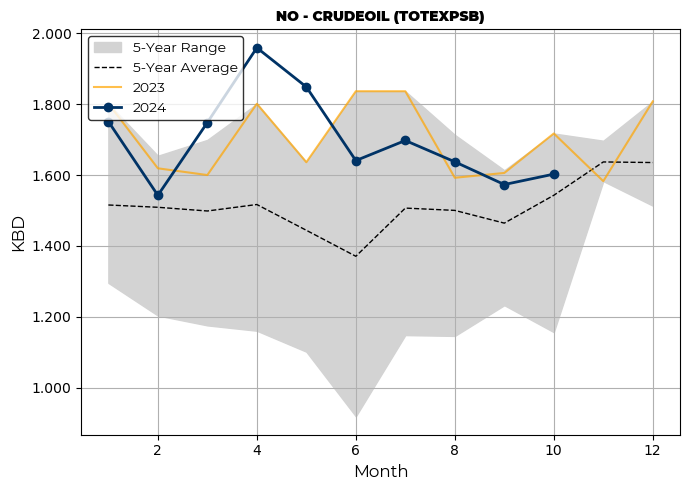

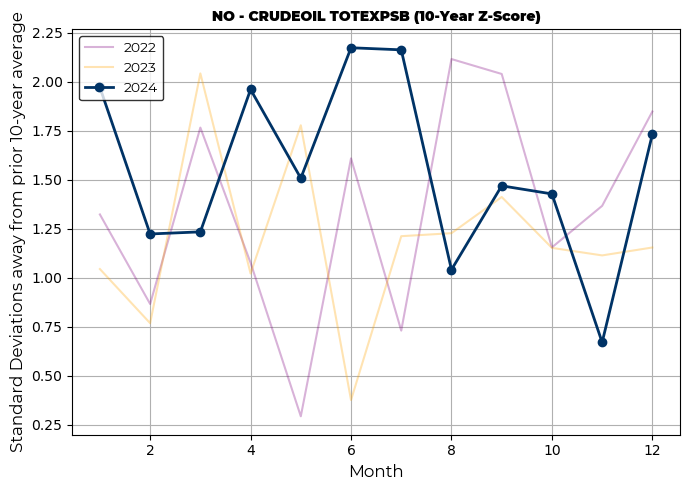

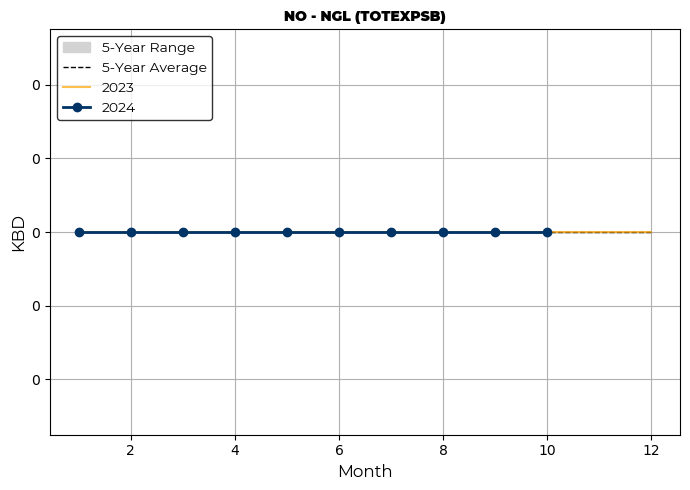

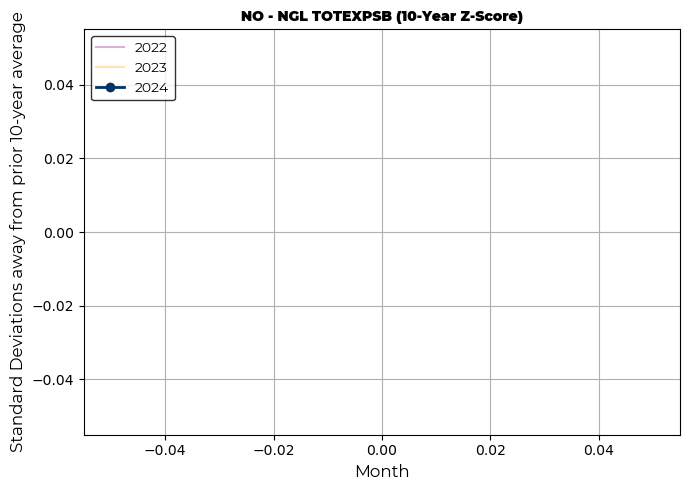

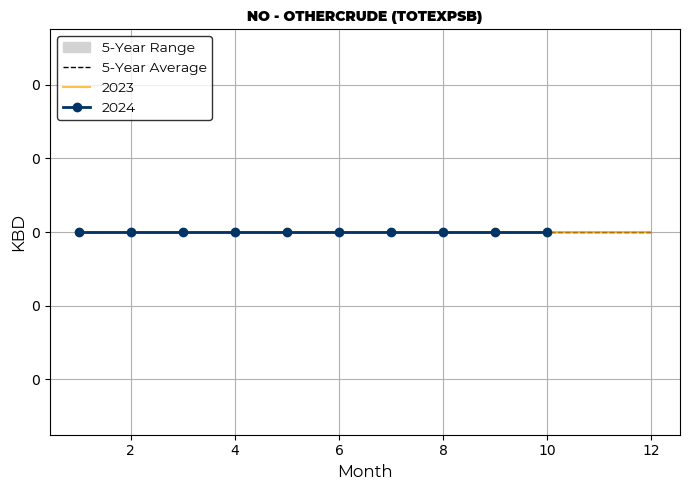

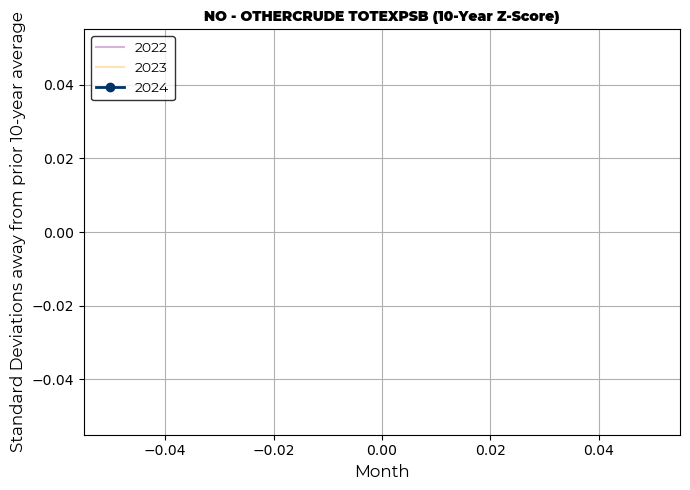

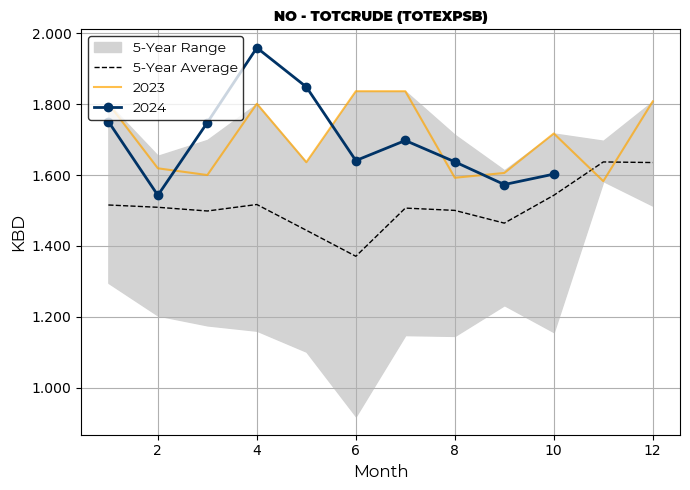

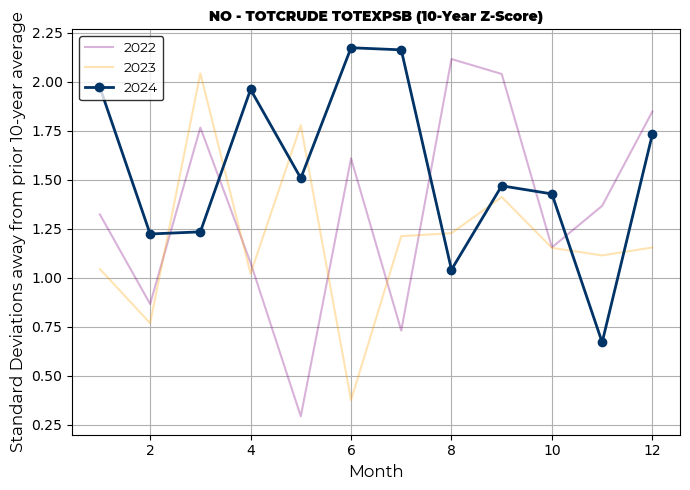

In [8]:
data_type = "primary"
flow_breakdown = "TOTEXPSB"
unit_measure = "KBD"
country_code = "NO"

generate_analysis(data_type, flow_breakdown, unit_measure, country_code)